# Overview of LASSO-CACTI Data and Ways to Work with it

**Author:** William.Gustafson@pnnl.gov  
**Date:** 13-May-2024

LASSO-CACTI consists of a library of large-eddy simulations for cases selected from the CACTI field campaign. The cases specifically target days with convective initiation within sampling distance of ARM's mobile facility and when the clouds grow as they propagate over the site and to the east. The NCAR NSF RELAMPAGO field campaign overlaps with a portion of CACTI, which provides additional observations. More information can be found at the following links.

* CACTI field campaign
    * [CACTI overview paper, Varble et al. (2021)](https://doi.org/10.1175/BAMS-D-20-0030.1)
    * [ARM's CACTI web page](https://www.arm.gov/research/campaigns/amf2018cacti)
    * [CACTI overview paper in BAMS, Varble et al. (2021)](https://doi.org/10.1175/bams-d-20-0030.1)
    * [Catalog of CACTI datasets in ARM's Data Discovery](https://adc.arm.gov/discovery/#/results/s::cacti) (observations, not the simulations)

* RELAMPAGO field campaign
    * [RELAMPAGO overview paper, Nesbitt et al. (2021)](https://doi.org/10.1175/BAMS-D-20-0029.1)
    * [Top-level RELAMPAGO web page](http://catalog.eol.ucar.edu/relampago)
    * [Interactive map of observations](http://catalog.eol.ucar.edu/maps/relampago)
    * [RELAMPAGO datasets](https://data.eol.ucar.edu/master_lists/generated/relampago/)

* LASSO-CACTI websites
    * [LASSO overview page](https://www.arm.gov/capabilities/modeling/lasso)
    * [LASSO-CACTI Technical Description](https://lasso-cacti-doc.arm.gov/latest/index.html)
    * [LASSO-CACTI Bundle Browser](https://adc.arm.gov/lasso/#/cacti) (for quick-look plots of simulations and to place orders to download simulations)

**Objectives of this notebook:**
1. Learn about the LASSO-CACTI subset files and some example ways of working with them in Python.
2. Examine the variability within a case dates's ensemble of simulations by comparing them to an observed radiosonde profile, both in terms of thermodynamics profiles on a Skew-T and for winds on a hodograph.
3. Learn how to plot the subsets on a map by looking at the simulated radar reflectivity.

In [1]:
# Libraries required for this tutorial...

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import os
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from matplotlib.ticker import MultipleLocator, FormatStrFormatter  # ticker spacing
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import metpy
import metpy.calc as mpcalc
from metpy.plots import colortables, Hodograph, SkewT
from metpy.units import units

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Simulation ensembles available for LASSO-CACTI

LASSO-CACTI provides ensembles of mesoscale simulations down to 2.5-km grid spacing for 20 case dates. Short descriptions of the dates can be found in the [documentation](https://lasso-cacti-doc.arm.gov/latest/case_selection.html) and additional information like satellite animations can be found in the [LASSO-CACTI Bundle Browser](https://adc.arm.gov/lasso/#/cacti). The simulations were run with a slightly modified version of the Weather Research and Forecast (WRF) model ([details](https://lasso-cacti-doc.arm.gov/latest/modeling_config.html)). The ensembles are built by using alternative input and boundary-condition datasets. Each date nominally has [33 ensemble members](https://lasso-cacti-doc.arm.gov/latest/modeling_inputs.html#tablemesoicbc) using the default model configuration. Some dates have additional members with alternate physics, such as a different microphysics parameterization.

LES simulations have been done for a subset of 9 case dates. These consist of two additional WRF domains with 500 and 100-m grid spacing, which are nested within the 2.5-km grid spacing domain. A small number of ensemble members exist for the LES cases, with the primary intent being to use the best-behaved mesoscale ensemble member to drive the LES. Getting good LES results sometimes took more than one attempt as a well-behaved mesoscale simulation does not ensure a well-behaved LES simulation.


### Identifying LASSO-CACTI simulations and files

Uniquely identifying LASSO-CACTI simulations requires the following information:

1. **Case date**, expressed as `YYYYmmddHH`, e.g., `2021020800`

2. **Forcing dataset**. Note that some (re)analyses consist of ensembles themselves. The input ensemble number is appended to the end of the forcing name. The possible forcing options are `fnl`, `gefsNN`, `era5`, and `edaNN` where NN is the input ensemble number as a two-digit integer, e.g. `eda05`.

3. **Configuration label**, which identifies the configuration or other unique aspects of the simulation. Most simulations have configuration lables of `base` for the default configuration, or `morr` when the microphysics is switched from Thompson to Morrison. Some other configurations were used for sensitivity testing and exploring model behavior.

Once you have identified the simulation of interest, three other pieces of information are necessary to uniquely identify a file within the LASSO-CACTI library.

4. **Domain number**, numbered from 1 through 4 for domains with grid spacings of 7.5 km, 2.5 km, 500 m, and 100 m, respectively. Within the filenames, the domain numbers are prepended with a "d", e.g., `d2`.

5. **Simulation time**, which is the specific time simulated within the chosen case date. This is expressed in the format `YYYYmmdd.HHMMSS`, e.g., `20190125.200000`.

6. **File type**. Each file type is identified with a short abbreviation of its name, e.g., `cld` for the subset of cloud variables. A full list of possible file types will follow below.

When you go into the [Bundle Browser](https://adc.arm.gov/lasso/#/cacti) to download a simulation file, it is the above six details that you need to select. Ultimately, you will get back a file named using the following convention:

&ensp; &ensp; Filename format: ```sssIIII.FFFFFF.YYYYmmddHHEEEENNdN.aaaa.Fn.dl.YYYYmmdd.HHMMSS.ext```  
&ensp; &ensp; Example filename: ```corlasso.methamsl.2019012900gefs05d4.base.M1.m0.20190129.153500.nc```  

This is similar to a standard ARM filename, but differs so that the various details can be captured for the different simulations. The site name and instrument at the beginning of the name is always the same for LASSO-CACTI, `corlasso`. One detail that differs from observations-based data from ARM is the data level, `dl`. The LASSO data type is "model" as indicated by an "m" and then the level is either `0` for raw model output or `1` for post-processed model output, such as the subset files.  A [table describing this in detail](https://lasso-cacti-doc.arm.gov/latest/file_descriptions.html#tablefilenameconvention) is in the documentation. For our purposes here, know you need to care about the six numbered items, above, and the other details come along for the ride.


### File types

Files provided with LASSO-CACTI include inputs for rerunning simulations, raw model output, and subsets of variables from the output. All the files are in netCDF format with the exception of the input files, which come as a tar file of the run directory from the corresponding WRF run. The documentation has a [table listing the specific variables included in each subset file type](https://lasso-cacti-doc.arm.gov/latest/file_descriptions.html#tablesubsetvariables) as well as the [levels for the subset data](https://lasso-cacti-doc.arm.gov/latest/file_descriptions.html#tablesubsetlevels).


**List of file types in LASSO-CACTI**
Category | Description
--       | --
wrfin    | Input files for WRF
wrfrst   | Restart file from a WRF simulation
wrfout   | Raw output from WRF, the wrfout file
aer      | Subset file: aerosol variables
cld      | Subset file: cloud variables and related diagnostics, e.g., LWP
cldhagl  | Subset file: cloud variables interpolated to heights above ground level
cldhamsl | Subset file: cloud variables interpolated to heights above mean sea level
cldpres  | Subset file: cloud variables interpolated to pressure levels
met      | Subset file: meteorological state variables and related diagnostics, e.g., CAPE
methagl  | Subset file: meteorological state variables interpolated to heights above ground level
methamsl | Subset file: meteorological state variables interpolated to heights above mean sea level
metpres  | Subset file: meteorological state variables interpolated to pressure levels
metst    | Subset file: meteorological state fields on staggered grids
pbl      | Subset file: planetary boundary layer variables
rad      | Subset file: radiation variables
sfc      | Subset file: surface and land module variables
stat     | Subset file: static variables
tend     | Subset file: tendency variables, predominately related to microphysics
trace    | Subset file: inert tracers


### Example file contents of a subset file

For the purposes of this tutorial, we will use the subset files. These are a more susinct way to obtain the files since one only neeeds to download the subset(s) containing the variables needed for a given application. The subsets also contain common diagnostic variables, such as convectivly available potential energy (CAPE), wind shear, and liquid water path (LWP). The most commonly used subset categories are the meteorology and cloud categories.

Below is the header information from a sample meteorology, "met," subset file. Note that unlike the raw WRF output, the time has been converted to a CF-compliant format, so xarray can read the file without doing extra processing to parse the time. Met subsets contain the typical meteorological state variables, e.g., temperature, pressure, moisture, and winds. Additionally, wind components rotated to earth-relative direction, equivalent potential temperature, wind shears, and CAPE-related variables are added based on calculations from the raw WRF output.

The cell below the met example shows the header from a cloud, "cld," subset file. This has the condensate mixing ratios, 3-D radar reflectivity, and a few diagnosed variables, e.g., liquid water path and precipitable water.

In [2]:
# File contents from a meteorology subset...

# path_staging = "/gpfs/wolf2/arm/cli120/world-shared/d3m088/cacti/staged_runs"  # path on cumulus
path_staging = "/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/cacti/lasso-cacti"  # path on Jupyter

filename = f"{path_staging}/20190123/eda09/base/meso/subset_d2/corlasso_met_2019012300eda09d2_base_M1.m1.20190123.120000.nc"
ds = xr.open_dataset(filename)
ds

<xarray.Dataset> Size: 718MB
Dimensions:               (Time: 1, south_north: 306, west_east: 258,
                           bottom_top: 149)
Coordinates:
  * Time                  (Time) datetime64[ns] 8B 2019-01-23T12:00:00
    XLONG                 (south_north, west_east) float32 316kB ...
    XLAT                  (south_north, west_east) float32 316kB ...
    XTIME                 (Time) float32 4B ...
Dimensions without coordinates: south_north, west_east, bottom_top
Data variables: (12/53)
    ITIMESTEP             (Time) int32 4B ...
    MUTOT                 (Time, south_north, west_east) float32 316kB ...
    HGT                   (Time, south_north, west_east) float32 316kB ...
    HAMSL                 (Time, bottom_top, south_north, west_east) float32 47MB ...
    P_HYD                 (Time, bottom_top, south_north, west_east) float32 47MB ...
    PRESSURE              (Time, bottom_top, south_north, west_east) float32 47MB ...
    ...                    ...
    MULNB                 (Time, south_north, west_east) float32 316kB ...
    MULPL                 (Time, south_north, west_east) float32 316kB ...
    MUCAPE                (Time, south_north, west_east) float32 316kB ...
    MUCIN                 (Time, south_north, west_east) float32 316kB ...
    REFL_10CM_MAX         (Time, south_north, west_east) float32 316kB ...
    RAINC                 (Time, south_north, west_east) float32 316kB ...
Attributes: (12/40)
    DX:                          2500.0
    DY:                          2500.0
    SIMULATION_START_DATE:       2019-01-23_00:00:00
    WEST-EAST_GRID_DIMENSION:    259
    SOUTH-NORTH_GRID_DIMENSION:  307
    BOTTOM-TOP_GRID_DIMENSION:   150
    ...                          ...
    doi_isPartOf_lasso-cacti:    https://doi.org/10.5439/1905789
    doi_isDocumentedBy:          https://doi.org/10.2172/1905845
    doi_thisFileType:            https://doi.org/10.5439/1905819
    NCO:                         netCDF Operators version 4.9.3 (Homepage = h...
    filename_user:               corlasso_met_2019012300eda09d2_base_M1.m1.20...
    filename_storage:            corlassomet2019012300eda09d2baseM1.m1.201901...

In [3]:
# Here is an example cloud subset file header...

filename = f"{path_staging}/20190123/eda09/base/meso/subset_d2/corlasso_cld_2019012300eda09d2_base_M1.m1.20190123.120000.nc"
ds = xr.open_dataset(filename)
ds

<xarray.Dataset> Size: 472MB
Dimensions:      (Time: 1, south_north: 306, west_east: 258, bottom_top: 149)
Coordinates:
  * Time         (Time) datetime64[ns] 8B 2019-01-23T12:00:00
    XLONG        (south_north, west_east) float32 316kB ...
    XLAT         (south_north, west_east) float32 316kB ...
    XTIME        (Time) float32 4B ...
Dimensions without coordinates: south_north, west_east, bottom_top
Data variables: (12/14)
    ITIMESTEP    (Time) int32 4B ...
    QCLOUD       (Time, bottom_top, south_north, west_east) float32 47MB ...
    QRAIN        (Time, bottom_top, south_north, west_east) float32 47MB ...
    QICE         (Time, bottom_top, south_north, west_east) float32 47MB ...
    QSNOW        (Time, bottom_top, south_north, west_east) float32 47MB ...
    QGRAUP       (Time, bottom_top, south_north, west_east) float32 47MB ...
    ...           ...
    QNCLOUD      (Time, bottom_top, south_north, west_east) float32 47MB ...
    REFL_10CM    (Time, bottom_top, south_north, west_east) float32 47MB ...
    CLDFRA       (Time, bottom_top, south_north, west_east) float32 47MB ...
    LWP          (Time, south_north, west_east) float32 316kB ...
    IWP          (Time, south_north, west_east) float32 316kB ...
    PRECIPWATER  (Time, south_north, west_east) float32 316kB ...
Attributes: (12/40)
    DX:                          2500.0
    DY:                          2500.0
    SIMULATION_START_DATE:       2019-01-23_00:00:00
    WEST-EAST_GRID_DIMENSION:    259
    SOUTH-NORTH_GRID_DIMENSION:  307
    BOTTOM-TOP_GRID_DIMENSION:   150
    ...                          ...
    doi_isPartOf_lasso-cacti:    https://doi.org/10.5439/1905789
    doi_isDocumentedBy:          https://doi.org/10.2172/1905845
    doi_thisFileType:            https://doi.org/10.5439/1905813
    NCO:                         netCDF Operators version 4.9.3 (Homepage = h...
    filename_user:               corlasso_cld_2019012300eda09d2_base_M1.m1.20...
    filename_storage:            corlassocld2019012300eda09d2baseM1.m1.201901...

## Comparing an ensemble to a radiosonde profile

Variability within the ensemble for a given day reflect the impact of subtle differences in the background meteorology ingested from the forcing datasets. To see how much the meteorology can differ, let's look at how the soundings compare from each ensemble member when plotted alongside the observed sounding.

Different tools exist for creating Skew-T plots. We will use the `metpy` module from Unidata.

We will define a few subroutines first to help us out.

In [4]:
# We will need to find the model grid point indices closest to the sounding...

def closest_ji(latfind, lonfind, latgrid, longrid):
    # Returns the indices (j,i) of the closest loctation in the lat/lon grid for a requested lat/lon.
    distance = np.abs((latgrid - latfind) ** 2 + (longrid - lonfind) ** 2)
    ji = np.unravel_index(np.argmin(distance), longrid.shape)

    return ji
# end closest_ji()

The `corsondewnpn` dataset is the standard ARM sounding data stream available fom the CACTI campaign.
For our purposes, we need pressure, temperature, dew point, and wind components. We also 
interpolate the data to 20 hPa vertical intervals to ease plotting.

In [5]:
# We need to read data from ARM's sounding files...

def read_sounding(plot_time, rootpath_snd):
    # Read sounding data from corsondewnpn datastream...

    # Open file for the selected time...
    filename_snd = f"{rootpath_snd}/corsondewnpnM1.b1.{plot_time:%Y%m%d.%H%M%S}.cdf"
    ds = xr.open_dataset(filename_snd)  # data in format of xarray Dataset
    df = ds.to_dataframe()  # data in form of Pandas DataFrame

    # Subset out variables of interest...
    lat = df['lat'].values
    lon = df['lon'].values
    # alt = df['alt'].values
    snd_p_raw = df['pres'].values  # * units.hPa
    snd_T_raw = df['tdry'].values  # * units.degC
    snd_Td_raw = df['dp'].values  # * units.degC
    snd_u_raw = df['u_wind'].values
    snd_v_raw = df['v_wind'].values

    # Interpolate sounding data for plotting wind barbs every 20 hPa...
    snd_p_intp = np.arange(snd_p_raw.max(), 100., -20)
    snd_T_intp, snd_Td_intp, snd_u_intp, snd_v_intp = metpy.interpolate.interpolate_1d(
        snd_p_intp,
        snd_p_raw,
        snd_T_raw,
        snd_Td_raw,
        snd_u_raw,
        snd_v_raw
    )
    return df, ds, lat, lon, snd_T_raw, snd_Td_raw, snd_p_intp, snd_p_raw, snd_u_intp, snd_u_raw, snd_v_intp, snd_v_raw, filename_snd
# end read_sounding()

Next, we'll set up code to read the WRF data. It is a bit overkill, but we use a class to pull the WRF data. This can make it easier to hold everything in one place when calling subroutines and tracking several open WRF datasets at the same time.

Specfic to the sounding application, we have a choice to make. The radiosonde blows away from the launch location while the balloon rises. The simplest comparison we can make to WRF is to neglect the balloon movement and compare the sounding to the instantaneous column from WRF at the launch location. Alternatively, a more sophisticated comparison samples the WRF data along the radiosonde track. We sample WRF both ways with the one assumption that the balloon completes its ascent instantaneously. This implies we can sample a single WRF output time along the ballon track, which is sufficient in most cases. Given that we have 5-minute output for the LES, one could sample in time as well, but that is left to the user to try.

In [6]:
# Define a class to read WRF subset files and pull the data we need...

class WrfData:
    def __init__(self, df_snd, ds_snd, plot_time, ens_member, domain, rootpath_wrf, snd_p_intp):
        # Need to find closest WRF output time...
        dt = 15 if domain < 4 else 5  # minutes between WRF output times (15 min. for D1-D3, 5 min. for D4)
        obs_minute = plot_time.minute
        nincrements = np.floor(obs_minute / dt)

        if obs_minute % dt != 0:  # determine how many minutes away from an output time has been requested (soundings can be unpredictable)
            diff = nincrements*dt - obs_minute
        else:
            diff = 0
        # end if
        
        if np.abs(diff) < 0.5 * dt:  # if minutes diff from obs to WRF times less than half the WRF time increment
            wrf_time = plot_time + timedelta(minutes=diff)  # can simply apply the minutes adjustment
        else:
            wrf_time = plot_time + timedelta(minutes=diff + dt)  # need to jump an increment plus the difference
        # end if

        # Get the WRF path and open the file...
        # This assumes the file folder structure used on ARM's cumulus cluster with data organized in a tree structure by  
        # date / ensemble member / configuration label / scale (meso or LES) / and file type.
        scale = "meso" if domain < 3 else "les"
        path_wrf_subset = f"{rootpath_wrf}/{wrf_time:%Y%m%d}/{ens_member[0]}/{ens_member[1]}/{scale}/subset_d{domain}"
        filename_wrf = f"{path_wrf_subset}/corlasso_met_{wrf_time:%Y%m%d}00{ens_member[0]}d{domain}_{ens_member[1]}_M1.m1.{wrf_time:%Y%m%d.%H%M}00.nc"

        if not os.path.isfile(filename_wrf):
            print("Could not find WRF file", filename_wrf)
            self.valid = False
            return
        else:
            self.valid = True
        # end if

        ds_wrf = xr.open_dataset(filename_wrf)
        itime = 0  # always just one time per subset file

        # Get location indices for pulling WRF sounding...
        xlat = ds_wrf.variables['XLAT'][:, :].values
        xlon = ds_wrf.variables['XLONG'][:, :].values
        snd_ji_sfc = closest_ji(ds_snd['lat'].values[0], ds_snd['lon'].values[0], xlat[:], xlon[:])
        j = snd_ji_sfc[0]
        i = snd_ji_sfc[1]

        # Pull WRF data for the column above the balloon launch location...
        wrf_p = ds_wrf.variables['PRESSURE'][itime, :, j, i].values
        wrf_tc = ds_wrf.variables['TEMPERATURE'][itime, :, j, i].values - 273.15  # convert from K to degC
        wrf_u = ds_wrf.variables['UMET'][itime, :, j, i].values  # NOTE: using earth-relative wind components and not the raw model wind data
        wrf_v = ds_wrf.variables['VMET'][itime, :, j, i].values
        qv = ds_wrf.variables['QVAPOR'][itime, :, j, i].values  # kg/kg
        e = mpcalc.vapor_pressure(wrf_p * units.hPa, qv)
        wrf_td = mpcalc.dewpoint(e)  # use metpy to get dew point in degC
        del (e)

        # Interpolate the WRF levels to the sounding pressure levels...
        wrf_tc_intp, wrf_td_intp, wrf_u_intp, wrf_v_intp = metpy.interpolate.interpolate_1d(
            snd_p_intp,
            wrf_p,
            wrf_tc,
            wrf_td,
            wrf_u, wrf_v
        )

        # Now, pull WRF data following the balloon path...
        # ...WRF will be sampled every 10 hPa based on top/bottom values between sonde and model
        wrf_snd_p = np.arange(np.min([df_snd['pres'].values[0], wrf_p[0]]), np.min([50, df_snd['pres'].values[-1]]), -10.)

        # ...initialize variables to hold the sampled track information
        wrf_snd_tc = np.zeros(wrf_snd_p.size, dtype='float')
        wrf_snd_qv = np.zeros(wrf_snd_p.size, dtype='float')
        wrf_snd_u = np.zeros(wrf_snd_p.size, dtype='float')
        wrf_snd_v = np.zeros(wrf_snd_p.size, dtype='float')
        wrf_snd_lat = np.zeros(wrf_snd_p.size, dtype='float')
        wrf_snd_lon = np.zeros(wrf_snd_p.size, dtype='float')

        # ...get the lat/lon values for each pressure level
        wrf_snd_lat, wrf_snd_lon = metpy.interpolate.interpolate_1d(
            wrf_snd_p,
            df_snd['pres'].values,
            df_snd['lat'].values,
            df_snd['lon'].values
        )

        # ...and then sample the WRF data to get the corresponding values along the track
        for sk in range(wrf_snd_p.size):
            sji = closest_ji(wrf_snd_lat[sk], wrf_snd_lon[sk], ds_wrf['XLAT'][:, :].values, ds_wrf['XLONG'][:, :].values)
            snd_p = wrf_snd_p[sk]
            wrf_p_prf = (ds_wrf['PRESSURE'][itime, :, sji[0], sji[1]].values)
            result = metpy.interpolate.interpolate_1d(
                snd_p,
                wrf_p_prf,
                ds_wrf['TEMPERATURE'][itime, :, sji[0], sji[1]].values - 273.15,
                ds_wrf['QVAPOR'][itime, :, sji[0], sji[1]].values,
                ds_wrf['UMET'][itime, :, sji[0], sji[1]].values,
                ds_wrf['VMET'][itime, :, sji[0], sji[1]].values
            )
            wrf_snd_tc[sk] = result[0][0]  # need to extract these piecemeal to avoid deprecation warning
            wrf_snd_qv[sk] = result[1][0]  # for assigning a single-element array to a scalar
            wrf_snd_u[sk] = result[2][0]
            wrf_snd_v[sk] = result[3][0]

        e = mpcalc.vapor_pressure(wrf_snd_p * units.hPa, wrf_snd_qv)
        wrf_snd_td = mpcalc.dewpoint(e)
        del (e)

        wrf_snd_tc_intp, wrf_snd_td_intp, wrf_snd_u_intp, wrf_snd_v_intp = metpy.interpolate.interpolate_1d(
            snd_p_intp,
            wrf_snd_p,
            wrf_snd_tc,
            wrf_snd_td,
            wrf_snd_u,
            wrf_snd_v
        )

        # Save the variables we care about to pass out of this subroutine...
        self.wrf_p = wrf_p  # the single-column version...
        self.wrf_tc = wrf_tc
        self.wrf_td = wrf_td
        self.wrf_u_intp = wrf_u_intp
        self.wrf_v_intp =wrf_v_intp

        self.wrf_snd_p = wrf_snd_p  # and, sampled along the moving balloon track...
        self.wrf_snd_tc = wrf_snd_tc
        self.wrf_snd_td = wrf_snd_td
        self.wrf_snd_u_intp = wrf_snd_u_intp
        self.wrf_snd_v_intp = wrf_snd_v_intp

        return
    # end init()
# end class WrfData

With the above routines defined, we can now proceed to plot overlayed soundings for all the ensemble members for a selected sounding.

In [9]:
# Define some user settings...

# Sounding time (also used to infer case date):
# plot_time = datetime(2018,10,26,16)
plot_time = datetime(2019,1,23,18)


# Colors to use when plotting each forcing type:
color_gefs = "dodgerblue"
color_eda = "darkorange"
color_era5 = "firebrick"
color_fnl = "blue"


# Ensemble members to plot:
# We encode these as lists of [ens_name, config_label, plotting_color]:
ens_members = [
    ["gefs00", "base", color_gefs],
    ["gefs01", "base", color_gefs],
    ["gefs02", "base", color_gefs],
    ["gefs03", "base", color_gefs],
    ["gefs04", "base", color_gefs],
    ["gefs05", "base", color_gefs],
    ["gefs06", "base", color_gefs],  # missing for 20190129
    ["gefs07", "base", color_gefs],
    ["gefs08", "base", color_gefs],  # missing for 20190129
    ["gefs09", "base", color_gefs],
    ["gefs10", "base", color_gefs],
    ["gefs11", "base", color_gefs],
    ["gefs12", "base", color_gefs],
    ["gefs13", "base", color_gefs],  # missing for 20190129
    ["gefs14", "base", color_gefs],
    ["gefs15", "base", color_gefs],
    ["gefs16", "base", color_gefs],  # missing for 20190129
    ["gefs17", "base", color_gefs],  # missing for 20190129
    ["gefs18", "base", color_gefs],
    ["gefs19", "base", color_gefs],
    ["gefs20", "base", color_gefs],  # missing for 20190129
    ["eda00", "base", color_eda],
    ["eda01", "base", color_eda],
    ["eda02", "base", color_eda],
    ["eda03", "base", color_eda],
    ["eda04", "base", color_eda],
    ["eda05", "base", color_eda],
    ["eda06", "base", color_eda],
    ["eda07", "base", color_eda],
    ["eda08", "base", color_eda],
    ["eda09", "base", color_eda],
    ["era5", "base", color_era5],
    ["fnl", "base", color_fnl],
]


# Domain number:
domain = 2


# Top-level data paths (pick on pair):
# ...on cumulus
# rootpath_wrf = "/gpfs/wolf2/arm/cli120/world-shared/d3m088/cacti/staged_runs"
# rootpath_snd = "/gpfs/wolf2/arm/cli120/proj-shared/sey/cacti/obs/sonde/arm"
# ...on Jupyter
rootpath_wrf = path_staging
rootpath_snd = f"{path_staging}/../corsondewnpn/"

# End of user settings. Now, do the work...

#-----------------------------------------------------------------------------------------
# First task is to read in all the information we need...

# Read the sounding data...
(df_snd, ds_snd, lat, lon, snd_T_raw, snd_Td_raw, snd_p_intp, snd_p_raw, snd_u_intp,
    snd_u_raw, snd_v_intp, snd_v_raw, filename_snd) = read_sounding(
    plot_time, rootpath_snd)


# Loop through the ensembles and read the WRF data...
wrf_datas = []  # I know, data is plural already, but give me some leeway here.
line_colors = []
for ens_member in ens_members:
    wrf_data = WrfData(df_snd, ds_snd, plot_time, ens_member, domain, rootpath_wrf, snd_p_intp)
    if wrf_data.valid:  # False indicates the file is missing
        wrf_datas.append(wrf_data)
        line_colors.append(ens_member[2])
    # end if
# end for

/tmp/ipykernel_774/1014473954.py:58: UserWarning: Interpolation point out of data bounds encountered
  wrf_tc_intp, wrf_td_intp, wrf_u_intp, wrf_v_intp = metpy.interpolate.interpolate_1d(
/tmp/ipykernel_774/1014473954.py:108: UserWarning: Interpolation point out of data bounds encountered
  wrf_snd_tc_intp, wrf_snd_td_intp, wrf_snd_u_intp, wrf_snd_v_intp = metpy.interpolate.interpolate_1d(
/tmp/ipykernel_774/1014473954.py:58: UserWarning: Interpolation point out of data bounds encountered
  wrf_tc_intp, wrf_td_intp, wrf_u_intp, wrf_v_intp = metpy.interpolate.interpolate_1d(
/tmp/ipykernel_774/1014473954.py:108: UserWarning: Interpolation point out of data bounds encountered
  wrf_snd_tc_intp, wrf_snd_td_intp, wrf_snd_u_intp, wrf_snd_v_intp = metpy.interpolate.interpolate_1d(
/tmp/ipykernel_774/1014473954.py:58: UserWarning: Interpolation point out of data bounds encountered
  wrf_tc_intp, wrf_td_intp, wrf_u_intp, wrf_v_intp = metpy.interpolate.interpolate_1d(
/tmp/ipykernel_774/1014473

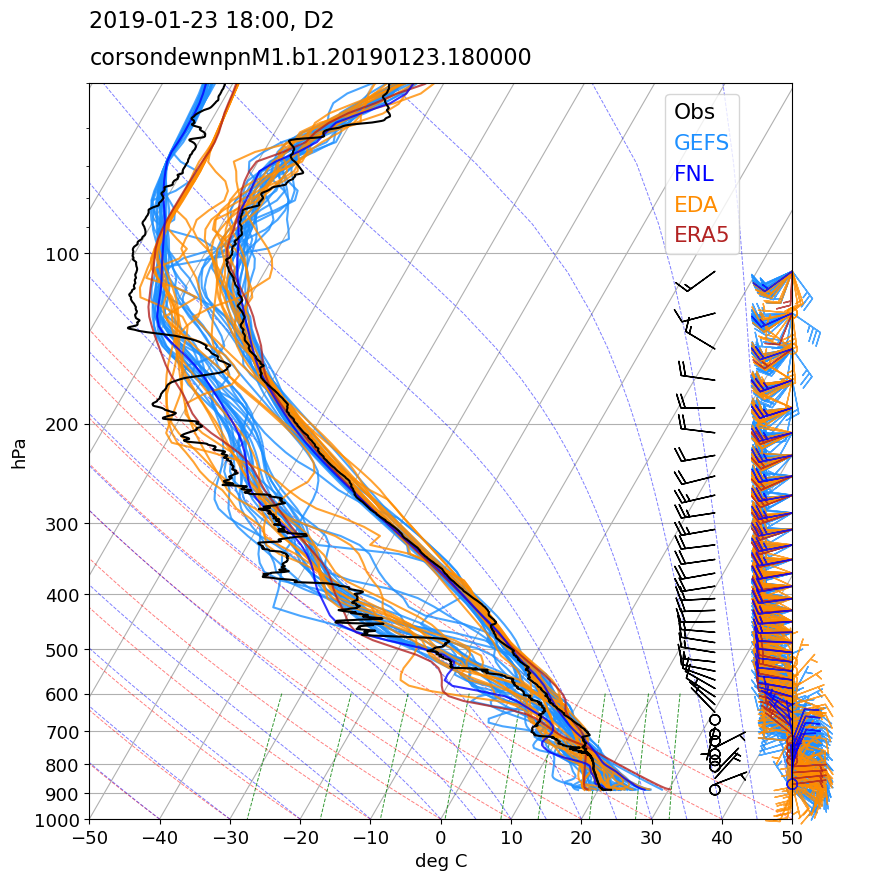

In [10]:
# Plot the Skew-T sounding...

plt.rcParams['font.size'] = 13

fig = plt.figure(figsize=(13, 9))
gs = gridspec.GridSpec(1, 1)  # , wspace=0)

skew = SkewT(fig, rotation=30, subplot=gs[:, :])  # use metpy's skew-T code

# WRF sounding lines for each ensemble member
# (pick one location type and comment out other version)
for i, wrf in enumerate(wrf_datas):
    line_color = line_colors[i]

    # Code for following balloon track
    # skew.plot(wrf.wrf_snd_p, wrf.wrf_snd_tc, line_color, alpha=0.8)
    # skew.plot(wrf.wrf_snd_p, wrf.wrf_snd_td, line_color, alpha=0.8)  # ,ls="dashed")
    # skew.plot_barbs(snd_p_intp, wrf.wrf_snd_u_intp, wrf.wrf_snd_v_intp, xloc=1, barbcolor=line_color, alpha=0.8)

    # Code for column above launch location
    skew.plot(wrf.wrf_p, wrf.wrf_tc, line_color, alpha=0.8)
    skew.plot(wrf.wrf_p, wrf.wrf_td, line_color, alpha=0.8)  # ,ls="dashed")
    skew.plot_barbs(snd_p_intp, wrf.wrf_u_intp, wrf.wrf_v_intp, xloc=1, barbcolor=line_color, alpha=0.8)
# end for

# Observed sounding line
skew.plot(snd_p_raw, snd_T_raw, 'k', lw="1.5")
skew.plot(snd_p_raw, snd_Td_raw, 'k', lw="1.5")  # , ls="dashed")
skew.plot_barbs(snd_p_intp, snd_u_intp, snd_v_intp, xloc=0.89)

# Axis limits
skew.ax.set_ylim(1000, 50)
skew.ax.set_xlim(-50, 50)

# Add the "special" lines
skew.plot_dry_adiabats(lw=0.7, color="#e41a1c")  # red
skew.plot_moist_adiabats(lw=0.7, color="#984ea3")  # purple
skew.plot_mixing_lines(lw=0.7, color="#dede00")  # yellow

# Add legend without lines, just the ens categories
leg = skew.ax.legend(["Obs", "GEFS", "FNL", "EDA", "ERA5"],
                        labelcolor=['black', color_gefs, color_fnl, color_eda, color_era5],
                        fontsize="large",
                        loc="upper right", bbox_to_anchor=(0.94, 0.99999),
                        handlelength=0, handletextpad=0)
for item in leg.legend_handles:
    item.set_visible(False)
# end for

# Titles at top and axis labels
sndtime = os.path.basename(filename_snd)
txt1 = plt.text(0.0, 1.05, '%s' % sndtime.replace(".cdf", ""), fontsize=16, transform=skew.ax.transAxes, ha='left',
                va='top')

title_plt = f"{plot_time:%Y-%m-%d %H:%M}, D{domain}"
txt2 = plt.text(0.0, 1.10, '%s' % title_plt, fontsize=16, transform=skew.ax.transAxes, ha='left', va='top')

skew.ax.set(xlabel="deg C", ylabel="hPa")

plt.tight_layout()
# plt.savefig(f"snd_ens_{plot_time:%Y%m%d%H%M}.pdf", bbox_inches='')
plt.show()

We can do a similar ensemble plot for a hodograph instead of a skew-T.

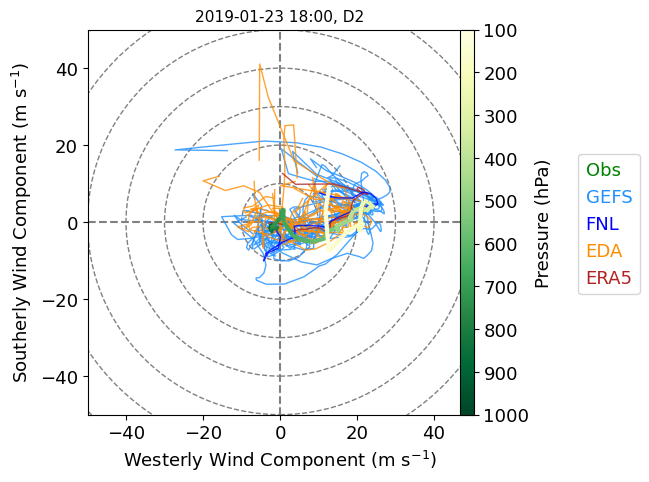

In [11]:
# Plot a hodograph for the ensemble of simulations...

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot title
title_plt = f"{plot_time:%Y-%m-%d %H:%M}, D{domain}"
ax.set_title(title_plt, fontsize=11)

# Set up the hodograph and its range rings
hodo = Hodograph(ax, component_range=50)
hodo.add_grid(increment=10)

# Loop over the ensemble members and plot each one
for i, wrf in enumerate(wrf_datas):
    line_color = line_colors[i]
    hodo.plot(wrf.wrf_u_intp, wrf.wrf_v_intp, color=line_color, alpha=0.8, linewidth=1.0)

# Lastly, overlay the observed winds using a green-to-yellow palette to infer the altitude
ahod = hodo.plot_colormapped(snd_u_intp, snd_v_intp, snd_p_intp, lw=3, cmap=cm.YlGn, norm=Normalize(vmin=100,vmax=1000))

# Add colorbar for pressure...
ax_r = fig.add_subplot(1, 2, 2)
ax_r.axis("off")  # turn off the bounding box since this axis does not get a plot
the_divider = make_axes_locatable(ax_r)
cax = the_divider.append_axes("right", size="10%")
cbar = fig.colorbar(ahod, cax=cax, label="Pressure (hPa)")
cbar.ax.invert_yaxis()

# Add axis labels for left column and bottom row...
ax.set_ylabel("Southerly Wind Component ($\mathregular{m\ s^{-1}}$)")
ax.set_xlabel("Westerly Wind Component ($\mathregular{m\ s^{-1}}$)")

# Add legend without lines, just the ens categories...
leg = fig.legend(["Obs", "GEFS", "FNL", "EDA", "ERA5"],
                        labelcolor=['green', color_gefs, color_fnl, color_eda, color_era5],
                        fontsize="medium",
                        bbox_to_anchor=(1.25, .65),
                        handlelength=0, handletextpad=0)
for item in leg.legend_handles:  # turn off the legend's lines
    item.set_visible(False)
# end for

# plt.savefig("hodographs.pdf")
plt.show()

## Plotting maps with LASSO-CACTI subset files

Plotting maps with Cartopy can be a bit tricky. Here is an example of this for the column-maximum radar reflectivity. Since one might want to plot times outside of when the soundings launched, we will start over with new user settings and reading of the WRF data. 

For an obseration comparison, we will use the Taranis dataset, which uses CSPAR data and applies an attentuation correction, velocity unfolding, and adds microphysics, rainrate, and hydrometeor identification retrievals. Background on Taranis can be found in this [PI Meeting poster by Hardin et al. (2019)](https://www.arm.gov/meetings/stm/posters/pdf/2019/P002174.pdf).

In [16]:
# User settings...

case_date = datetime(2019, 1, 29)
time_to_plot = case_date + timedelta(hours=20, minutes=15)

domain = 4  # Options=1, 2, 3, 4 for dx=7500, 2500, 500, and 100 m grid spacing, respectively
ens_name = "eda09"
config_label = "base"

# Top-level data paths:
# ...on cumulus
# rootpath_wrf = path_staging
# path_taranis = "/gpfs/wolf2/arm/cli120/proj-shared/d3m088/cacti/data/taranis/merged_radar+sat_asof20210826"
# ...on Jupyter
rootpath_wrf = path_staging
path_taranis = f"{path_staging}/../taranis"
print(path_taranis)
# End of user settings.

#--------------------------------------------------------------

# Get the WRF path and open the file...
# This assumes the file folder structure used on ARM's cumulus cluster with data organized in a tree structure by  
# date / ensemble member / configuration label / scale (meso or LES) / and file type.
scale = "meso" if domain < 3 else "les"
path_wrf_subset = f"{rootpath_wrf}/{time_to_plot:%Y%m%d}/{ens_name}/{config_label}/{scale}/subset_d{domain}"
filename_wrf = f"{path_wrf_subset}/corlasso_met_{time_to_plot:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{time_to_plot:%Y%m%d.%H%M}00.nc"

ds_wrf = xr.open_dataset(filename_wrf)
itime = 0  # always just one time per subset file

# Get the variables we need for plotting...
wlat = ds_wrf['XLAT'][:, :]
wlon = ds_wrf['XLONG'][:, :]
whgt = ds_wrf['HGT'][itime, :, :]  # terrain height

variable_name = "REFL_10CM_MAX"
wdata = ds_wrf[variable_name][itime, :, :]


# Get the Taranis radar data...
# Sample times from the observations are a bit unpredictable. So, we will open a time series for the whole day and then select the nearest time.
ds_tar = xr.open_mfdataset(f"{path_taranis}/taranis_corcsapr2cfrppiqcM1_convmask.c1.{case_date:%Y%m%d}.*.nc")
ds_tar = ds_tar.sel(time=time_to_plot, method="nearest")

tlat = ds_tar["latitude"]
tlon = ds_tar["longitude"]
tdata = ds_tar["dbz_comp"]

/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/cacti/lasso-cacti/../taranis


OSError: no files to open

When working with maps, there are two map details to worry about. The first is the way the map is shown to the reader. This is the projection defined when setting up the matplotlib axis. The scond is the format/units of the location information attached to the data. For the latter, always rememeber to tell matplotlib how your data's coordinates are encoded. Often, the position information is in lat/lon coordinates, so the commands get sent `transform=PlateCaree()`.

In [ ]:
# Make the plot of composite/column-maximum radar reflectivity...
# We will put the observed reflectivity in a lefthand panel with the simulated relfectivity in a righthand panel.

# Set up color information
norm, cmap = colortables.get_with_steps('NWSStormClearReflectivity', -20, 0.5)  # dbZ

# Set up the map projection and plot axes
# The LASSO-CACTI subset files contain the necessary attributes to define WRF's map projection.
# We will use the WRF projection for displaying both the Taranis and WRF plots so they look the same for comparing values.
proj = ccrs.LambertConformal(central_latitude=ds_wrf.attrs["MOAD_CEN_LAT"],
                             central_longitude=ds_wrf.attrs["STAND_LON"],
                             standard_parallels=[ds_wrf.attrs["TRUELAT1"], ds_wrf.attrs["TRUELAT2"]])  # output projection, i.e., the one displayed
fig, axs = plt.subplots(1, 2, figsize=[12,5.5], dpi=100, subplot_kw=dict(projection=proj))


#-------------------------------------------------------------------
# Plot the Taranis data in the left panel...
ax = axs[0]

# Set the min/max coordinates to plot (using corners of WRF domain)
lonsmin = np.min(wlon)
lonsmax = np.max(wlon)
latsmin = np.min(wlat)
latsmax = np.max(wlat)
map_extent = [lonsmin, lonsmax, latsmin, latsmax]
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':45}
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.top_labels = None
gl.right_labels = None

# Plot the actual data of interest
pcm = ax.pcolormesh(tlon.values, tlat.values, tdata.values, 
                    shading='auto', norm=norm, cmap=cmap, 
                    transform=ccrs.PlateCarree())

# Overlay selected terrain height contours for getting a sense of location
ax.contour(wlon.values, wlat.values, whgt.values, 
            levels=[500, 1000, 1500, 2000], 
            colors='k', linewidths=1.0,  
            transform=ccrs.PlateCarree())

# Add a star for the AMF location
lat_cordoba = (-1.)*(32.+(7./60.)+(35.076/3600.))
lon_cordoba = (-1.)*(64.+(43./60.)+(42.132/3600.))
ax.scatter(lon_cordoba, lat_cordoba, c='w', marker='*', s=150, zorder=3, 
            transform=ccrs.PlateCarree())

# Finish off with some labelling
# time_label = f"{time_to_plot:%Y-%m-%d %H:%M} UTC"
time_label = f"{pd.to_datetime(ds_tar['time'].values):%Y-%m-%d %H:%M} UTC"  # time comes in as datetime64 and need to convert to datetime
ax.set_title(f"Taranis Composite Reflectivity\n{time_label}")


#-------------------------------------------------------------------
# Plot the WRF data in the right panel...
ax = axs[1]

# Set the min/max coordinates to plot
lonsmin = np.min(wlon)
lonsmax = np.max(wlon)
latsmin = np.min(wlat)
latsmax = np.max(wlat)
map_extent = [lonsmin, lonsmax, latsmin, latsmax]
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':45}
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.top_labels = None
gl.right_labels = None

# Plot the actual data of interest
pcm = ax.pcolormesh(wlon.values, wlat.values, wdata.values, 
                    shading='auto', norm=norm, cmap=cmap, 
                    transform=ccrs.PlateCarree())
cbar = plt.colorbar(pcm, ax=ax, shrink=.85, pad=0.02, extend='both')
cbar.ax.set_ylabel(f"{wdata.name} ({wdata.attrs['units']})")

# Overlay selected terrain height contours for getting a sense of location
ax.contour(wlon.values, wlat.values, whgt.values, 
            levels=[500, 1000, 1500, 2000], 
            colors='k', linewidths=1.0, 
            transform=ccrs.PlateCarree())

# Add a star for the AMF location
lat_cordoba = (-1.)*(32.+(7./60.)+(35.076/3600.))
lon_cordoba = (-1.)*(64.+(43./60.)+(42.132/3600.))
ax.scatter(lon_cordoba, lat_cordoba, c='w', marker='*', s=150, zorder=3, 
           transform=ccrs.PlateCarree())

# Finish off with some labelling
time_label = f"{time_to_plot:%Y-%m-%d %H:%M} UTC"
run_info_label = f"Case={case_date:%Y-%m-%d}; Ensemble={ens_name}; Config={config_label}; Dom={domain}"
ax.set_title(f"WRF Column-Max Reflectivity (lambda=10 cm)\n{time_label}")
plt.annotate(run_info_label, (0.8,0.01), horizontalalignment="right", xycoords="figure fraction", fontsize='x-small')

plt.show()


## Additional details and datasets to explore

* ARM released radiosondes both west (site S1) and east (site M1) of the ridge. Comparing conditions up and downwind of the ridge can be interesting. The RELAMPAGO campaign also released soundings and has produced a composite dataset with all the available soundings; see the [RELAMPAGO Data Listing](https://data.eol.ucar.edu/master_lists/generated/relampago/) and search for "Sounding Composites". (Note that the lowest-level temperature may be incorrect for the ARM sounding data included in the composite dataset, but the temperature has been corrected in ARM's corsondewnpn dataset.)
* [Parallax-corrected VISST GOES-16 satellite data](https://adc.arm.gov/discovery/#/results/id::211_macro_visst_satellite_cldoptdepth?showDetails=true) is great to get a birds-eye sense of the clouds.
* Working with rain data is complicated to get the details correct, e.g., see [this code example](https://code.arm.gov/lasso/lasso-cacti/rain_analysis/-/tree/main?ref_type=heads).


## List of LASSO-CACTI data pre-staged for the 2024 ARM Summer School

* Observations
    * ARM's soundings for locations M1 (at the AMF east of the ridgeline) and S1 (at the Villa Dolores airport west of the ridgeline)
        * ARM download link: https://adc.arm.gov/discovery/#/results/s::corsondewnpn
        * Staged path on Wolf2: /gpfs/wolf2/arm/atm124/world-shared/arm-summer-school-2024/lasso_tutorial/cacti/corsondewnpn/
        * Staged path on Jupyter: TBD
    * CSPAR2 radar data processed with Taranis software
        * Staged path on Wolf2: /gpfs/wolf2/arm/atm124/world-shared/arm-summer-school-2024/lasso_tutorial/cacti/taranis/
        * Staged path on Jupyter: TBD
* LASSO-CACTI simulation subsets
    * All case date's "base" mesoscale subsets for domain 2 (dx=2.5 km) for `met`, `cld`, `methamsl`, `cldhamsl`, and `stat` subset categories
    * 29-Jan-2019 case: all four domains for "base" configuration and EDA09 forcing, same subsets as above
    * 8-Feb-2019 case: all four domains for "morr" configuration and EDA03 forcing, same subsets as above
    * Locations
        * Staged path on Wolrf2: /gpfs/wolf2/arm/atm124/world-shared/arm-summer-school-2024/lasso_tutorial/cacti/lasso-cacti
        * Staged path on Jupyter: TBD